In [1]:
%%capture
from dopamine.discrete_domains import run_experiment
import gin.tf
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
EXPLORATION_LOG_PATH = '../../tmp/exploration_data.pkl'

In [3]:
# Delete old pickle file if it exists
if os.path.exists(EXPLORATION_LOG_PATH):
    os.remove(EXPLORATION_LOG_PATH)

In [11]:
gin_file_path = f'../jax/agents/full_rainbow/configs/atari/full_rainbow_vpd_simhash_exploration.gin'
gin.parse_config_file(gin_file_path, skip_unknown=False)

gin.bind_parameter("atari_lib.create_atari_environment.game_name", "Frostbite")
gin.bind_parameter("Runner.num_iterations", 100)
gin.bind_parameter("JaxFullRainbowAgent.pickle_output", True)

save_log_path = f'../../tmp/'
rainbow_runner = run_experiment.create_runner(save_log_path, schedule='continuous_train')
rainbow_runner.run_experiment()

KeyboardInterrupt: 

In [12]:
def plot_average_over_episodes(data_list, labels, save_path=""):
    plt.figure()
    plt.title(f"Average Across Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Average Value")
    
    vpd_color = (197/255, 58/255, 50/255)  # RGB values for VPD
    simhash_color = (59/255, 117/255, 175/255)  # RGB values for SimHash 
    colors = [vpd_color, simhash_color]

    for data, label, color in zip(data_list, labels, colors):
        # Calculate the average for each episode
        episode_means = [np.mean(episode_data) for episode_data in data]
        plt.plot(episode_means, label=f"Average {label}", linewidth=2, color=color)
    
    plt.legend()

    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()

Total steps: 23634
Number of episodes: 15
Exploratory proportion: 0.0094
Value Promise Discrepancies - Mean: 0.7110529866889058
Value Promise Discrepancies - StdDev: 1.122709117500692
Value Promise Discrepancies - Max: 6.617403984069824
Value Promise Discrepancies - Min: 0.0
State Bonuses - Mean: 0.19544479553790448
State Bonuses - StdDev: 0.2650641415212573
State Bonuses - Max: 1.0
State Bonuses - Min: 0.006533854641020298


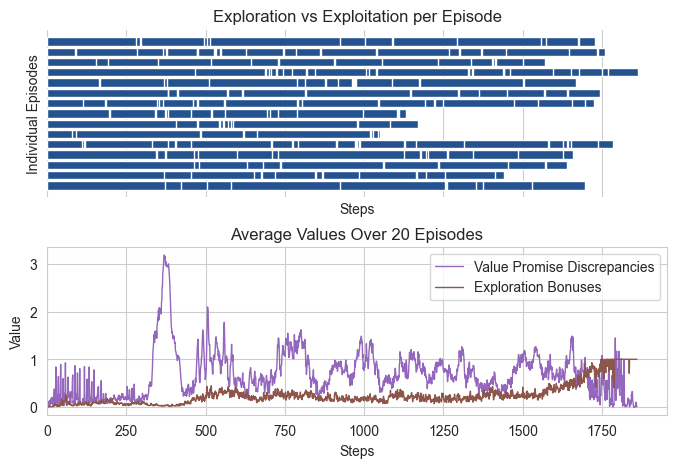

In [144]:
def plot_and_stats(data_list, labels, ax, save_path=""):
    ax.set_title(f"Average Values Over {len(data_list[0])} Episodes")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Value")

    vpd_color = '#9467bd'
    simhash_color = '#8c564b'
    colors = [vpd_color, simhash_color]
    
    for data, label, color in zip(data_list, labels, colors):
        # Calculate the average across episodes for each step
        max_length = max(len(episode_data) for episode_data in data)
        aligned_data = np.array([np.pad(episode_data, (0, max_length - len(episode_data)), mode='constant', constant_values=np.nan) for episode_data in data])
        average_data = np.nanmean(aligned_data, axis=0)
        
        if label == "State Bonuses":
            label = "Exploration Bonuses"

        ax.plot(average_data, label=f"{label}", linewidth=1, color=color, alpha=1, linestyle="-")

    ax.legend()

    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()
    
    for data, label in zip(data_list, labels):
        # Basic statistics
        all_data_flat = np.concatenate(data)
        print(f"{label} - Mean: {np.mean(all_data_flat)}")
        print(f"{label} - StdDev: {np.std(all_data_flat)}")
        print(f"{label} - Max: {np.max(all_data_flat)}")
        print(f"{label} - Min: {np.min(all_data_flat)}")

def plot_exploration(data, ax, save_path=""):
    num_episodes = len(data)
    episode_lengths = [len(episode) for episode in data]

    # Draw full bars (representing the length of each episode)
    ax.barh(range(num_episodes), episode_lengths, color=(0.14,0.32,0.56), align='center', height=0.8, label='Total Steps')

    # Overlay exploration steps
    for idx, episode in enumerate(data):
        exploit_count = 0
        for step, is_exploratory in enumerate(episode):
            if is_exploratory:
                ax.barh(idx, 1, left=exploit_count, color='magenta', align='center', height=0.8, label='Exploration')
            exploit_count += 1

    # Remove individual episode numbers on the y-axis and set the y-label
    ax.set_yticks([])
    ax.set_ylabel('Individual Episodes')

    # Remove the box around the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xlabel('Steps')
    ax.set_title('Exploration vs Exploitation per Episode')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()

with open('../../tmp/exploration_data.pkl', 'rb') as f:
    logging_data = pickle.load(f)

start_index, end_index = -20, None

exploration_data = [episode['exploration_decisions'] for episode in logging_data]
exploration_data = exploration_data[-15:end_index]

vpd_data = [episode['vpds'] for episode in logging_data]
vpd_data = vpd_data[start_index:end_index]
state_bonus_data = [episode['state_bonuses'] for episode in logging_data]
state_bonus_data = state_bonus_data[start_index:end_index]

state_bonus_data = [[bonus / 10 for bonus in episode] for episode in state_bonus_data]

# Compute the total number of exploratory steps and total steps
total_exploratory_steps = sum(sum(episode) for episode in exploration_data)
total_steps = sum(len(episode) for episode in exploration_data)
# Calculate the total exploration percentage across all episodes
exploratory_proportion = (total_exploratory_steps / total_steps)

print('Total steps:', total_steps)
print('Number of episodes:', len(exploration_data))
print('Exploratory proportion:', round(exploratory_proportion, 4))

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True, gridspec_kw={'hspace': 0.3})

# Plot the exploration data
plot_exploration(exploration_data, axs[0], save_path='../../results/exploration_plots/exploration_over_episodes.png')

# Plot VPD and exploration bonus across episodes
plot_and_stats([vpd_data, state_bonus_data], ["Value Promise Discrepancies", "State Bonuses"], axs[1], save_path='../../results/exploration_plots/values_over_episodes.png')

# Adjust layout to remove extra white space
plt.tight_layout()

fig.savefig('../../results/exploration_plots/values_over_episodes.pdf')